# Wavelet analysis

In [1]:
import numpy as np
import scipy.io as sio
import scipy.signal as signal
from matplotlib import pyplot as plt
import copy

# Required for interactive plots in DataSpell
# import matplotlib
# matplotlib.use("nbagg")

### Load data

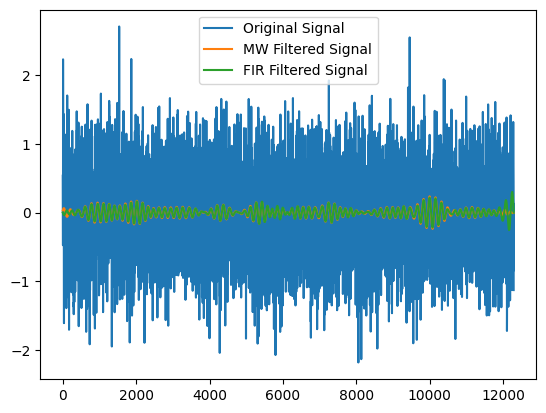

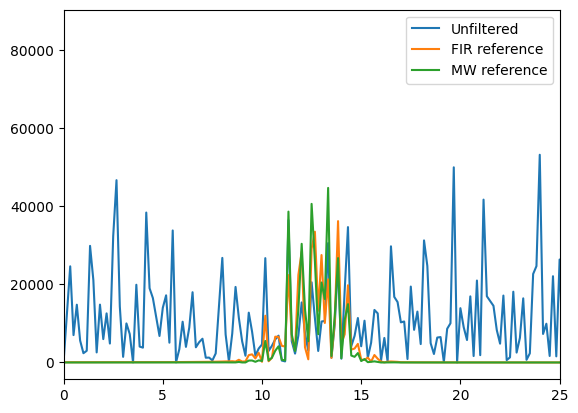

In [2]:
challengeData = sio.loadmat("Datasets/wavelet_codeChallenge.mat")

originalSignal = challengeData['signal'].flatten()
fs = challengeData['srate'].flatten()[0]
signalReferenceFIR = challengeData['signalFIR'].flatten()
signalReferenceMW = challengeData['signalMW'].flatten()
n = originalSignal.size

# Make plotting a fft easier
def plotFFT(data: np.ndarray, label: str = None, ax=None):
    frequencies = np.fft.rfftfreq(data.size, 1/fs)
    # power = np.abs(np.fft.rfft(data) / data.size)**2
    power = np.abs(np.fft.rfft(data))**2

    if ax is None:
        ax = plt.gca()

    ax.plot(frequencies, power, label=label)

# Visualize original and reference signals
plt.figure()
plt.plot(originalSignal, label='Original Signal')
plt.plot(signalReferenceMW, label='MW Filtered Signal')
plt.plot(signalReferenceFIR, label='FIR Filtered Signal')
plt.legend()

plt.figure()
plotFFT(originalSignal, label="Unfiltered")
plotFFT(signalReferenceFIR, label="FIR reference")
plotFFT(signalReferenceMW, label="MW reference")
plt.legend()
plt.xlim(0, 25)
plt.show()

### Goal: reproduce these FIR and MW filtered signals.
Inspecting the signals, it seems that they are centered around 12.5Hz [10-15].


### FIR filter

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


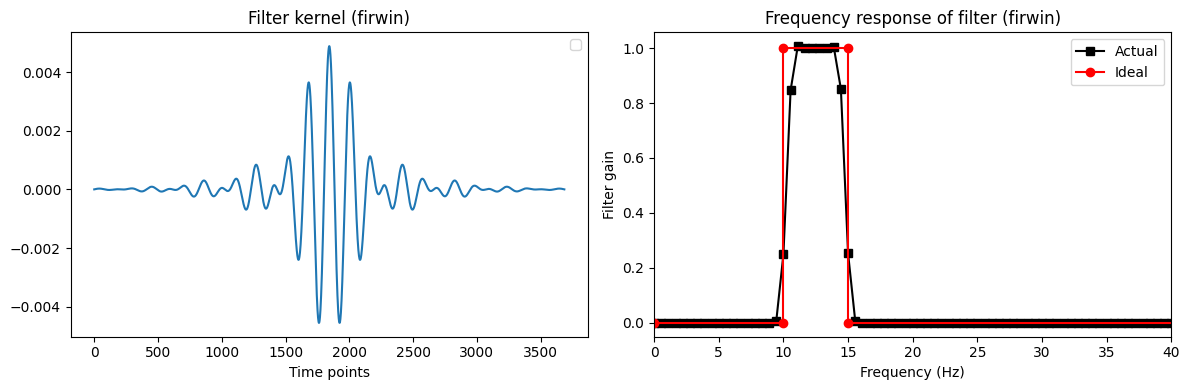

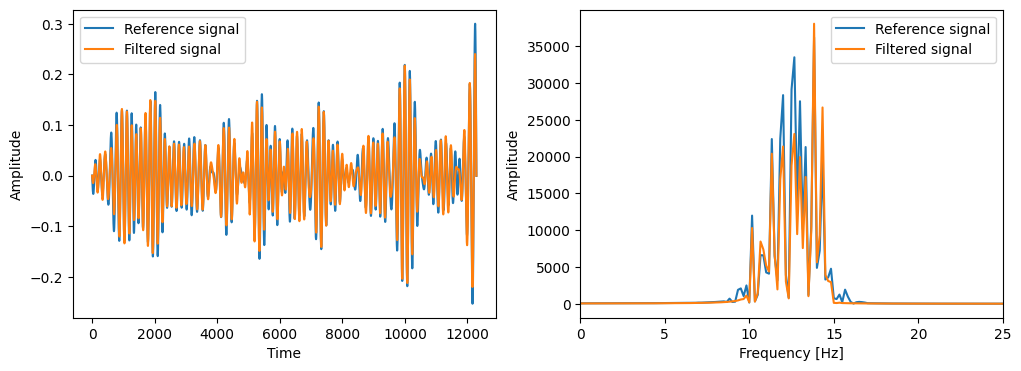

In [3]:
# filter parameters
nyquist = fs/2
frange  = [10, 15]
transw  = .1
order   = int(18 * fs/frange[0])

# force odd order
if order%2==0:
    order += 1

# Create filter kernel
filtkern = signal.firwin(order, frange, fs=fs, pass_zero=False)

# Plot filter kernel characteristics
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(filtkern)
axs[0].set_xlabel('Time points')
axs[0].set_title('Filter kernel (firwin)')

# compute the power spectrum of the filter kernel
filtpow = np.abs(np.fft.fft(filtkern))**2

# compute the frequencies vector and remove negative frequencies
hz      = np.linspace(0, fs/2, int(np.floor(len(filtkern)/2)+1))
filtpow = filtpow[0:len(hz)]

# plot amplitude spectrum of the filter kernel
axs[1].plot(hz, filtpow, 'ks-', label='Actual')
axs[1].plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'ro-',label='Ideal')
axs[1].set_xlim([0,frange[0]*4])
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Filter gain')
axs[1].set_title('Frequency response of filter (firwin)')
axs[0].legend()
axs[1].legend()
plt.tight_layout()


# Apply filter
FIRSignal = signal.filtfilt(filtkern, 1, originalSignal)


# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(signalReferenceFIR, label="Reference signal")
axs[0].plot(FIRSignal, label="Filtered signal")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

plotFFT(signalReferenceFIR, label="Reference signal", ax=axs[1])
plotFFT(FIRSignal, label="Filtered signal", ax=axs[1])
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("Amplitude")
axs[1].legend()
axs[1].set_xlim(0, 25)

plt.show()


Fairly close, good enough. Interesting that I supress more in the bandpass region (12.5Hz) compared to the reference, even though the gain is uniformly 1. Does the reference have a gain > 1?

### Filter using convoltion with Morlet Wavelet kernel

C:\Users\lucan\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\lucan\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


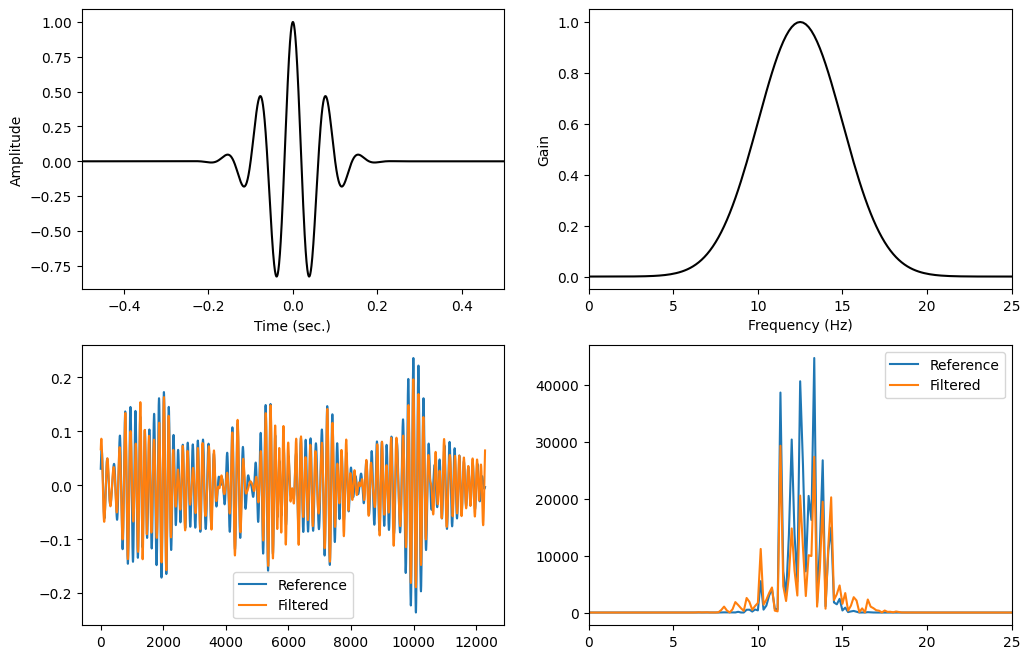

In [4]:
## create and inspect the Morlet wavelet

# wavelet parameters
ffreq = 12.5  # filter frequency in Hz
fwhm  = .15 # full-width at half-maximum in seconds
wavtime = np.arange(-3, 3, 1/fs) # wavelet time vector (same sampling rate as signal!)

# create the wavelet
morwav = np.cos(2*np.pi*ffreq*wavtime) * np.exp( -(4*np.log(2)*wavtime**2) / fwhm**2 )

# amplitude spectrum of wavelet
wavehz  = np.linspace(0, fs/2, int(np.floor(len(wavtime)/2)+1))
morwavX = 2 * np.abs(np.fft.fft(morwav))

# Normalize wavelet to set gain to 1
morwavX = morwavX / np.max(morwavX)

# Apply filter
fSignal = np.fft.fft(originalSignal) * morwavX
MWSignal = np.fft.ifft(fSignal)


# plot it
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.plot(wavtime, morwav,'k')
plt.xlim([-.5,.5])
plt.xlabel('Time (sec.)')
plt.ylabel("Amplitude")

plt.subplot(222)
plt.plot(wavehz, morwavX[:len(wavehz)],'k')
plt.xlim([0,ffreq*2])
plt.xlabel('Frequency (Hz)')
plt.ylabel("Gain")

plt.subplot(223)
plt.plot(signalReferenceMW, label="Reference")
plt.plot(MWSignal, label="Filtered")
plt.legend()

plt.subplot(224)
plotFFT(signalReferenceMW, label="Reference")
plotFFT(MWSignal, label="Filtered")
plt.legend()
plt.xlim(0, 25)

plt.show()

Again, quite close! Not perfect, though.